<a href="https://colab.research.google.com/github/GiPaiva/Sismos-Globais/blob/main/Earthquake_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sismos Globais – USGS Earthquake Catalog

Integrantes: **Giovanna Paiva Alves** e **Matheus Sanchez Duda**

O catálogo sísmico global é mantido pelo United States Geological Survey (USGS). Os dados são coletados a partir de redes de sismógrafos distribuídos mundialmente e consolidados automaticamente, passando por processos de verificação por sismólogos antes de serem disponibilizados ao público.

# Conectando ao Dataset

Para conectar ao dataset/API, usamos a biblioteca `requests` para fazer requisições HTTP e obter os dados em formato JSON. Lendo a documentação encontramos o endpoint `https://earthquake.usgs.gov/fdsnws/event/1/`, que é o caminho, como se fosse o email do dataset, para requisar os dados

In [190]:
# É assim que o dado vem
# Os dados estão dentro de 'features' e cada evento tem 'properties'
# {'mag': 5.1, 'place': 'Tonga', 'time': 1673105434004, 'updated': 1678575105040, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us7000j2tk', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000j2tk&format=geojson', 'felt': None, 'cdi': None, 'mmi': None, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 400, 'net': 'us', 'code': '7000j2tk', 'ids': ',us7000j2tk,', 'sources': ',us,', 'types': ',origin,phase-data,', 'nst': 61, 'dmin': 2.504, 'rms': 0.76, 'gap': 54, 'magType': 'mww', 'type': 'earthquake', 'title': 'M 5.1 - Tonga'}


## Bibliotecas:

In [191]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Ligação com o Dataset

**"starttime": "2025-01-01", <br>
"endtime": "2025-12-30",**
<br><br>
Escolhemos a janela de 2025-01-01 / 2025-12-31 , para então pegar do ano inteiro, "Mas ué, o ano ainda não acabou como você vai pegar o dados do que ainda não chegou?", quando eu faço a requisição ele me traz o que tiver disponivel e não me retorna erro nenhum, e então se eu rodar de novo outro dia, não precisaria mudar a data ele vai me trazer o atualizado.

**"minmagnitude": 5.5,**

A escolha da magnitude foi por conta de segundo pesquisas em sites como G1 e Fundação Oswaldo Cruz:
"
Terremotos a partir de magnitude 5,5 já têm potencial para causar danos destrutivos, especialmente em edifícios mal construídos.
"

Se formos ver a escala Richter:
<table>
<tr>
<th>Magnitude (Escala Richter)</th>
<th>Efeitos Típicos</th>
</tr>
<tr>
<td>Menos de 3,5	</td><td>Geralmente não sentido, apenas registrado por sismógrafos.</td>
</tr>
<tr>
<td>3,5 - 5,4	</td><td>Frequentemente sentido, mas raramente causa danos estruturais.</td>
</tr>
<tr>
<td>5,5 - 6,0	</td><td>Danos menores em edifícios bem projetados; danos significativos em construções precárias.</td>
</tr>
<tr>
<td>6,1 - 6,9	</td><td>Pode ser devastador em áreas habitadas num raio de até 180 km.</td>
</tr>
<tr>
<td>7,0 - 7,9	</td><td>Grande terremoto, causando danos graves e destruição em zonas vastas. </td>
</tr>
<tr>
<td>8,0 ou mais</td>	<td>Pode destruir totalmente comunidades perto do epicentro e causar danos sérios num raio de centenas de quilômetros.</td>
</tr>
</table>

Como felizmente esse tipo de terremotos que chegam até essa magnitude 5.5 é até que baixas nosso dataset não estará sobrecarregado, porem só de precaução por ser um dataset bem grande e com uma taxa de atualização alta, um filtro de limite de 20000 foi colocado.

### Quais serão os dados que vamos coletar?

Não acho que um terremoto vá ter um relógio para saber quando agir, mas assim saberemos quantos por dia podem estar acontecendo ;) <br>
**'data_hora'**: Quando aconteceu? Data e a hora Completa <br>
**'data'**: Apenas a data para podermos fazer métricas <br>
**'magnitude'**: A magnitude do terremoto, para sabermos com  base na escala, o quão destrutivel foi <br>
**'profundidade_km'**: Area sentida <br> <br>
Localizações <br>
**'latitude'**: <br>
**'longitude'**: <br>
**'localizacao'**: <br>
<br>
**'tipo'**: Isso é mais pela causa, por exemplo podemos ter diferentes tipo de atividade sismicas, pode ser: vulcanica, tectônica, colapso, explosão. <br>
**'tsunami'**: Ja esse dado nos retorna um booleano se esse abalo sismico teve como consequencia um tsunami <br>

In [192]:
print("🌍 Iniciando coleta de dados do Dataset...")
print("=" * 80)

url_base = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Parâmetros para coletar dados desde de janeiro 2025, pegando o ano todo
parametros = {
    "format": "geojson",
    "starttime": "2025-01-01",
    "endtime": "2025-12-30",
    "minmagnitude": 5.5,
    "limit": 20000
}

🌍 Iniciando coleta de dados do Dataset...


In [193]:
print("📥 Fazendo requisição ao Dataset...")
resposta = requests.get(url_base, params=parametros)

if resposta.status_code == 200:
    print("✅ Dados obtidos com sucesso!")
    dados_json = resposta.json()

    # Extrair dados dos eventos
    lista_eventos = []

    for evento in dados_json['features']:
        props = evento['properties']
        coords = evento['geometry']['coordinates']

        # Converter timestamp para datetime, para tornar a data e hora legíveis
        timestamp = props['time'] / 1000
        data_hora = datetime.fromtimestamp(timestamp)

        evento_dict = {
            'data_hora': data_hora,
            'data': data_hora.date(),
            'magnitude': props['mag'],
            'profundidade_km': coords[2],
            'latitude': coords[1],
            'longitude': coords[0],
            'localizacao': props['place'],
            'tipo': props['type'],
            'tsunami': props['tsunami']
        }

        lista_eventos.append(evento_dict)

    # Criar DataFrame
    df = pd.DataFrame(lista_eventos)

    print(f"📊 Total de eventos coletados: {len(df)}")
    print("=" * 80)

else:
    print(f"❌ Erro na requisição: {resposta.status_code}")

📥 Fazendo requisição ao Dataset...
✅ Dados obtidos com sucesso!
📊 Total de eventos coletados: 474


In [194]:
df.to_csv('dataset_sismos.csv', index=False)

# 3° parte - ARIMA

Média móvel integrada autorregressiva (Autoregressive Integrated Moving Average) ARIMA, uma técnica para análise de séries temporais e forecasting de possíveis valores futuros de uma série temporal.

Para a escolha do modelo de ARIMA, precisamos dos resultados das funções de ACF e PACF

Existem três parâmetros principais para um modelo ARIMA, que normalmente são chamados de p, d e q.

AR - p: a ordem da parte autorregressiva do ARIMA

I - d: o grau de diferenciação envolvido

MA - q: a ordem da parte da média móvel


| Padrão                    | O que significa     | Modelo       |
| ------------------------- | ------------------- | ------------ |
| **PACF corta no lag 1**   | AR(1)               | ARIMA(1,d,0) |
| **PACF corta no lag k**   | AR(k)               | ARIMA(k,d,0) |
| **ACF corta no lag 1**    | MA(1)               | ARIMA(0,d,1) |
| **ACF corta no lag k**    | MA(k)               | ARIMA(0,d,k) |
| ACF e PACF decaem devagar | ARMA                | ARIMA(p,d,q) |
| ACF muito alta em lag 1   | precisa diferenciar I | d=1          |


Para esse caso eu ecolhi <br>
p: 2, d: 1 e q: 2 <br>
ARIMA (2,1,2)
<br><br>
Mas porque? <br>
Temos o ACF bem alto em lag 1 então d=1
Ja em relação a AR e MA, o corte em ambos os PACF e ACF são no lag 2, ou seja, p= 2 e q=2.

Primeiro as bibliotecas para podermos acessar o ARRIMA

In [195]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [196]:
# Agrupar eventos por dia
eventos_por_dia = df.groupby('data').size()
eventos_por_dia_df = eventos_por_dia.reset_index()
eventos_por_dia_df.columns = ['data', 'quantidade']

H0: Não é estacionária

Ha: É estacionária

In [197]:
serie_temporal = eventos_por_dia_df['quantidade'].values

adf_test = adfuller(serie_temporal)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

if adf_test[1] <= 0.05:
  print("Rejeitamos a hipótese nula. A série é estacionária.")
else:
  print("Não rejeitamos a hipótese nula. A série não é estacionária.")

ADF Statistic: -9.979462
p-value: 0.000000
Rejeitamos a hipótese nula. A série é estacionária.


Ou seja, isso significa que <br>
<p>
"é uma série temporal cujas propriedades estatísticas, como média e variância, não mudam ao longo do tempo" - site Analise Macro
<br>
Sem sazonalidade, sem padrões repetitivos em intervalos fixos.
<br>
Perfeito para o ARIMA que exige que os dados de entrada sejam estacionários para que as previsões sejam válidas e precisas.


In [198]:
# Treino (85%) e teste (15%)
tamanho_treino = int(len(serie_temporal) * 0.85)
treino = serie_temporal[:tamanho_treino]
teste = serie_temporal[tamanho_treino:]

print(f"📊 Dados de treino: {len(treino)} dias")
print(f"📊 Dados de teste: {len(teste)} dias")

# Treinar 🏋️‍♀️
print("\n🔄 Treinando modelo ARIMA (2,1,2)...")

modelo = ARIMA(treino, order=(2, 1, 2))
modelo_treinado = modelo.fit()

print("✅🏋️‍♀️ Modelo treinado com sucesso!")
print("\n🥸 Resumo do Modelo:")
print(modelo_treinado.summary())

📊 Dados de treino: 194 dias
📊 Dados de teste: 35 dias

🔄 Treinando modelo ARIMA (2,1,2)...
✅🏋️‍♀️ Modelo treinado com sucesso!

🥸 Resumo do Modelo:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  194
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -431.796
Date:                Sun, 30 Nov 2025   AIC                            873.591
Time:                        21:57:40   BIC                            889.905
Sample:                             0   HQIC                           880.198
                                - 194                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5216      0.140     -3.718      0.000      -0

Primeiro separei a série em duas partes: 85% dos dados para treinar e 15% para testar. Omotivo foi pela quantidade de dados que temos até o momento de 2025.

Com os dados de treino prontos, ajustei o modelo usando a propria biblioteca do ARIMA colocando nossos numeros de parametros (2,1,2) — que foi escolhido porque o ACF e o PACF mostraram que a série tinha dependência até o segundo lag, tanto nos valores quanto nos erros, como falei anteriormente.

No resumo do modelo mostra que os dois termos AR (ar.L1 e ar.L2) e o segundo termo MA (ma.L2) foram bem significativos. Isso nos mostra que a série depende dos últimos dois dias para prever o próximo, e que o erro também tem um comportamento parecido. O termo ma.L1 não ficou significativo, pois, quanto menor melhor.

Ja o teste de Ljung–Box, que deu um p-valor de 0.85, significa que o modelo limpou praticamente toda a autocorrelação dos resíduos, ou seja, o que sobrou depois da modelagem parece ruído aleatório. Já os testes de normalidade e heterocedasticidade deram resultados diferentes (p=0.00), o que já era esperados porque estamos lidando com eventos dificeis de prever, tanto que no mundo real a previsão dos abalos sismicos são feitos por IA e outras machine learnings, junto de instrumentos.<br>

Isso ja foi discutido com até mesmo os donos do Dataset: <br>
https://www-usgs-gov.translate.goog/faqs/can-you-predict-earthquakes?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=sge#:~:text=Os%20cientistas%20do%20USGS%20só,local%20e%203)%20a%20magnitude.


📊 MÉTRICAS DE AVALIAÇÃO:
   • MSE (Erro Quadrático Médio): 2.21
   • RMSE (Raiz do MSE): 1.49
   • Média dos dados de teste: 2.06
   • Erro relativo: 72.3%


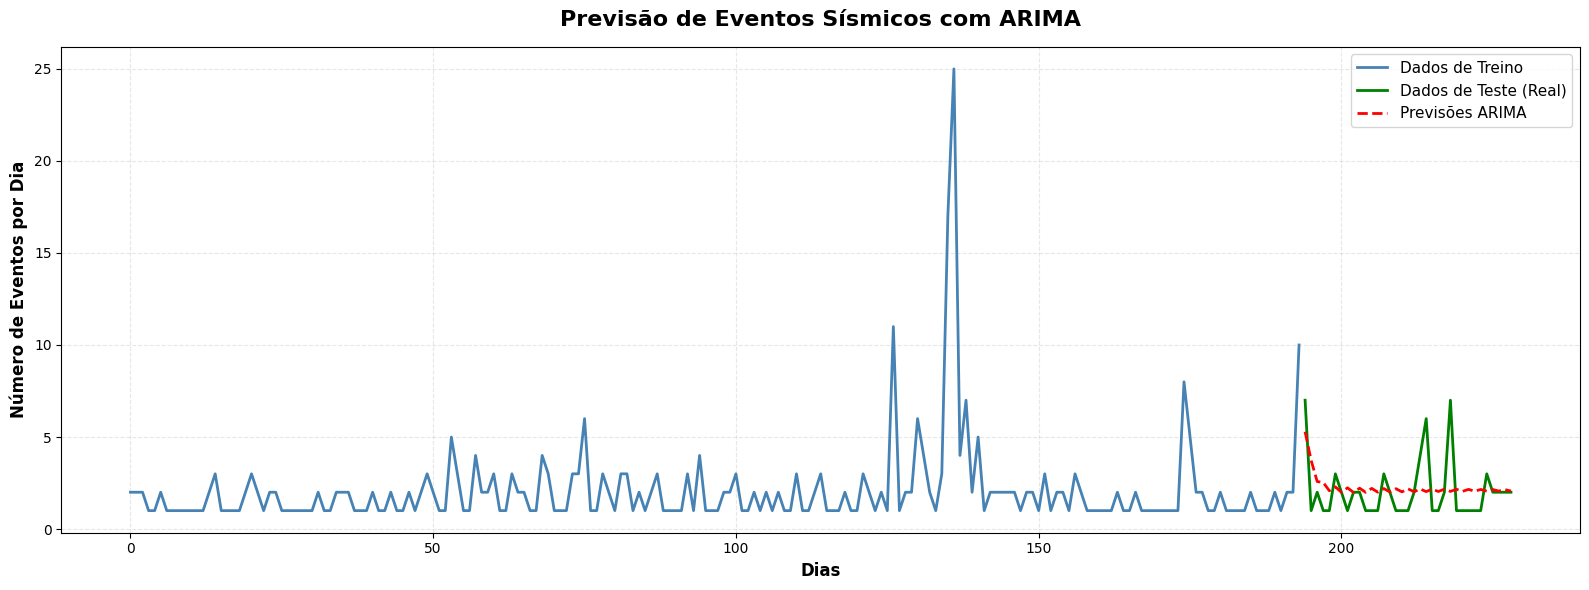

In [199]:
# Fazer previsões
previsoes = modelo_treinado.forecast(steps=len(teste))

# Calcular erro
mse = mean_squared_error(teste, previsoes)
rmse = np.sqrt(mse)

print(f"\n📊 MÉTRICAS DE AVALIAÇÃO:")
print(f"   • MSE (Erro Quadrático Médio): {mse:.2f}")
print(f"   • RMSE (Raiz do MSE): {rmse:.2f}")
print(f"   • Média dos dados de teste: {teste.mean():.2f}")
print(f"   • Erro relativo: {(rmse/teste.mean())*100:.1f}%")

# Plotar resultados
plt.figure(figsize=(16, 6))

# Dados de treino
plt.plot(range(len(treino)), treino, label='Dados de Treino',
         color='steelblue', linewidth=2)

# Dados de teste (real)
plt.plot(range(len(treino), len(serie_temporal)), teste,
         label='Dados de Teste (Real)', color='green', linewidth=2)

# Previsões
plt.plot(range(len(treino), len(serie_temporal)), previsoes,
         label='Previsões ARIMA', color='red', linewidth=2, linestyle='--')

plt.title('Previsão de Eventos Sísmicos com ARIMA',
          fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Número de Eventos por Dia', fontsize=12, fontweight='bold')
plt.xlabel('Dias', fontsize=12, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('previsao_arima.png', dpi=300, bbox_inches='tight')
plt.show()